In [2]:
%matplotlib inline
import sys 
sys.path.append('..')
from preamble import *
from matplotlib.pyplot import rc
rc('font',family='New Gulim')

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OneHotEncoder

In [4]:
X, y = mglearn.datasets.make_wave(n_samples=100)
line = np.linspace(-3, 3, 1000, endpoint=False).reshape(-1, 1)

bins = np.linspace(-3, 3, 11)
which_bin = np.digitize(X, bins=bins)

encoder = OneHotEncoder(sparse=False)
encoder.fit(which_bin)
X_binned = encoder.transform(which_bin)

line_binned = encoder.transform(np.digitize(line, bins=bins))

In [5]:
citibike = mglearn.datasets.load_citibike()

print("시티바이크 데이터 :\n{}".format(citibike.head()))

시티바이크 데이터 :
starttime
2015-08-01 00:00:00     3
2015-08-01 03:00:00     0
2015-08-01 06:00:00     9
2015-08-01 09:00:00    41
2015-08-01 12:00:00    39
Freq: 3H, Name: one, dtype: int64


Text(0,0.5,'대여횟수')

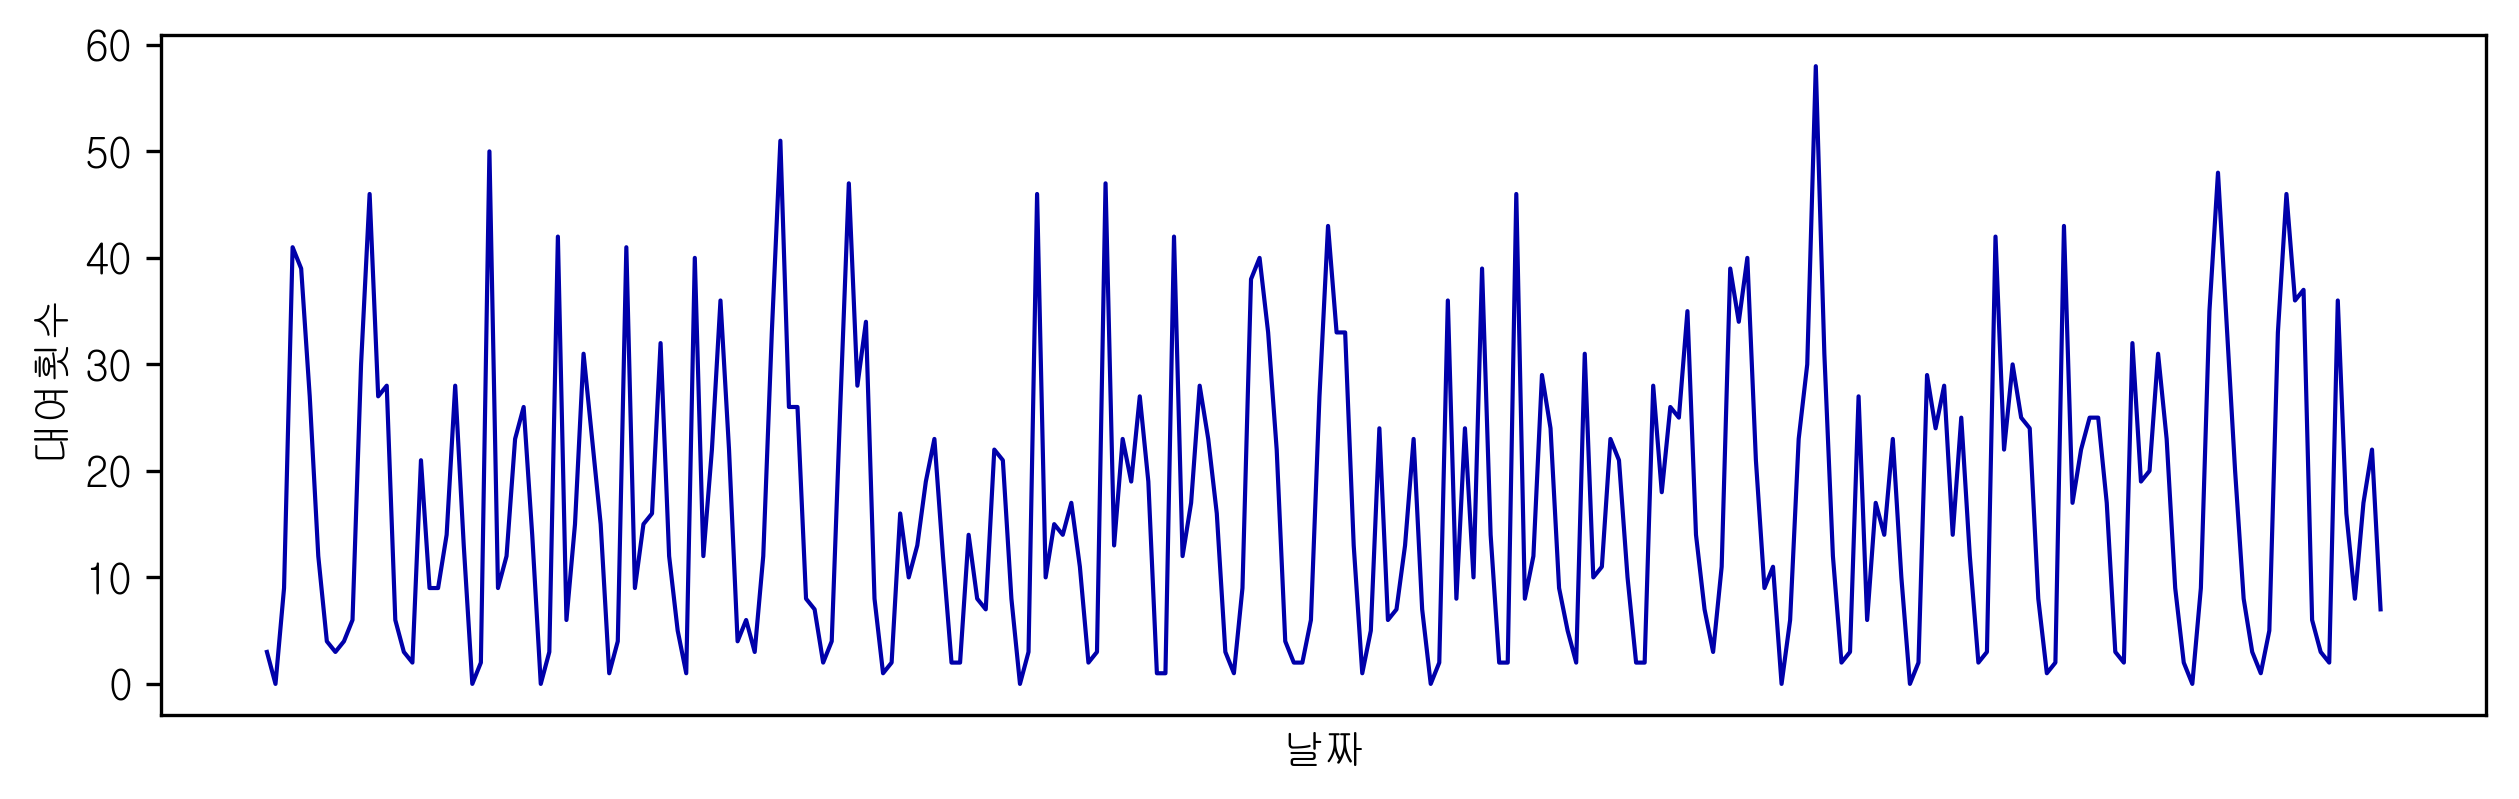

In [6]:
plt.figure(figsize=(10, 3))
xticks = pd.date_range(start=citibike.index.min(), end=citibike.index.max(),
                       freq='D')
week = ["일", "월", "화","수", "목", "금", "토"]
xticks_name = [week[int(w)]+d for w, d in zip(xticks.strftime("%w"), 
                                              xticks.strftime(" %m-%d"))]
plt.xticks(xticks.astype(int), xticks_name, rotation=90, ha="left")
plt.plot(citibike, linewidth=1)
plt.xlabel("날짜")
plt.ylabel("대여횟수")

In [7]:
# 타깃값 추출 (대여 횟수)
y = citibike.values
# POSIX 시간을 10**9로 나누어 변경
X = citibike.index.astype("int64").values.reshape(-1, 1) // 10**9

In [8]:
# 처음 184개 데이터 포인트를 훈련 세트로 사용하고 나머지는 테스트 세트로 사용합니다
n_train = 184

# 주어진 특성을 사용하여 평가하고 그래프를 만듭니다
def eval_on_features(features, target, regressor):
    # 훈련 세트와 테스트 세트로 나눕니다
    X_train, X_test = features[:n_train], features[n_train:]
    # 타깃값도 나눕니다
    y_train, y_test = target[:n_train], target[n_train:]
    regressor.fit(X_train, y_train)
    print("테스트 세트 R^2: {:.2f}".format(regressor.score(X_test, y_test)))
    y_pred = regressor.predict(X_test)
    y_pred_train = regressor.predict(X_train)
    plt.figure(figsize=(10, 3))

    plt.xticks(range(0, len(X), 8), xticks_name, rotation=90, ha="left")

    plt.plot(range(n_train), y_train, label="훈련")
    plt.plot(range(n_train, len(y_test) + n_train), y_test, '-', label="테스트")
    plt.plot(range(n_train), y_pred_train, '--', label="훈련 예측")

    plt.plot(range(n_train, len(y_test) + n_train), y_pred, '--',
             label="테스트 예측")
    plt.legend(loc=(1.01, 0))
    plt.xlabel("날짜")
    plt.ylabel("대여횟수")
    

테스트 세트 R^2: -0.04


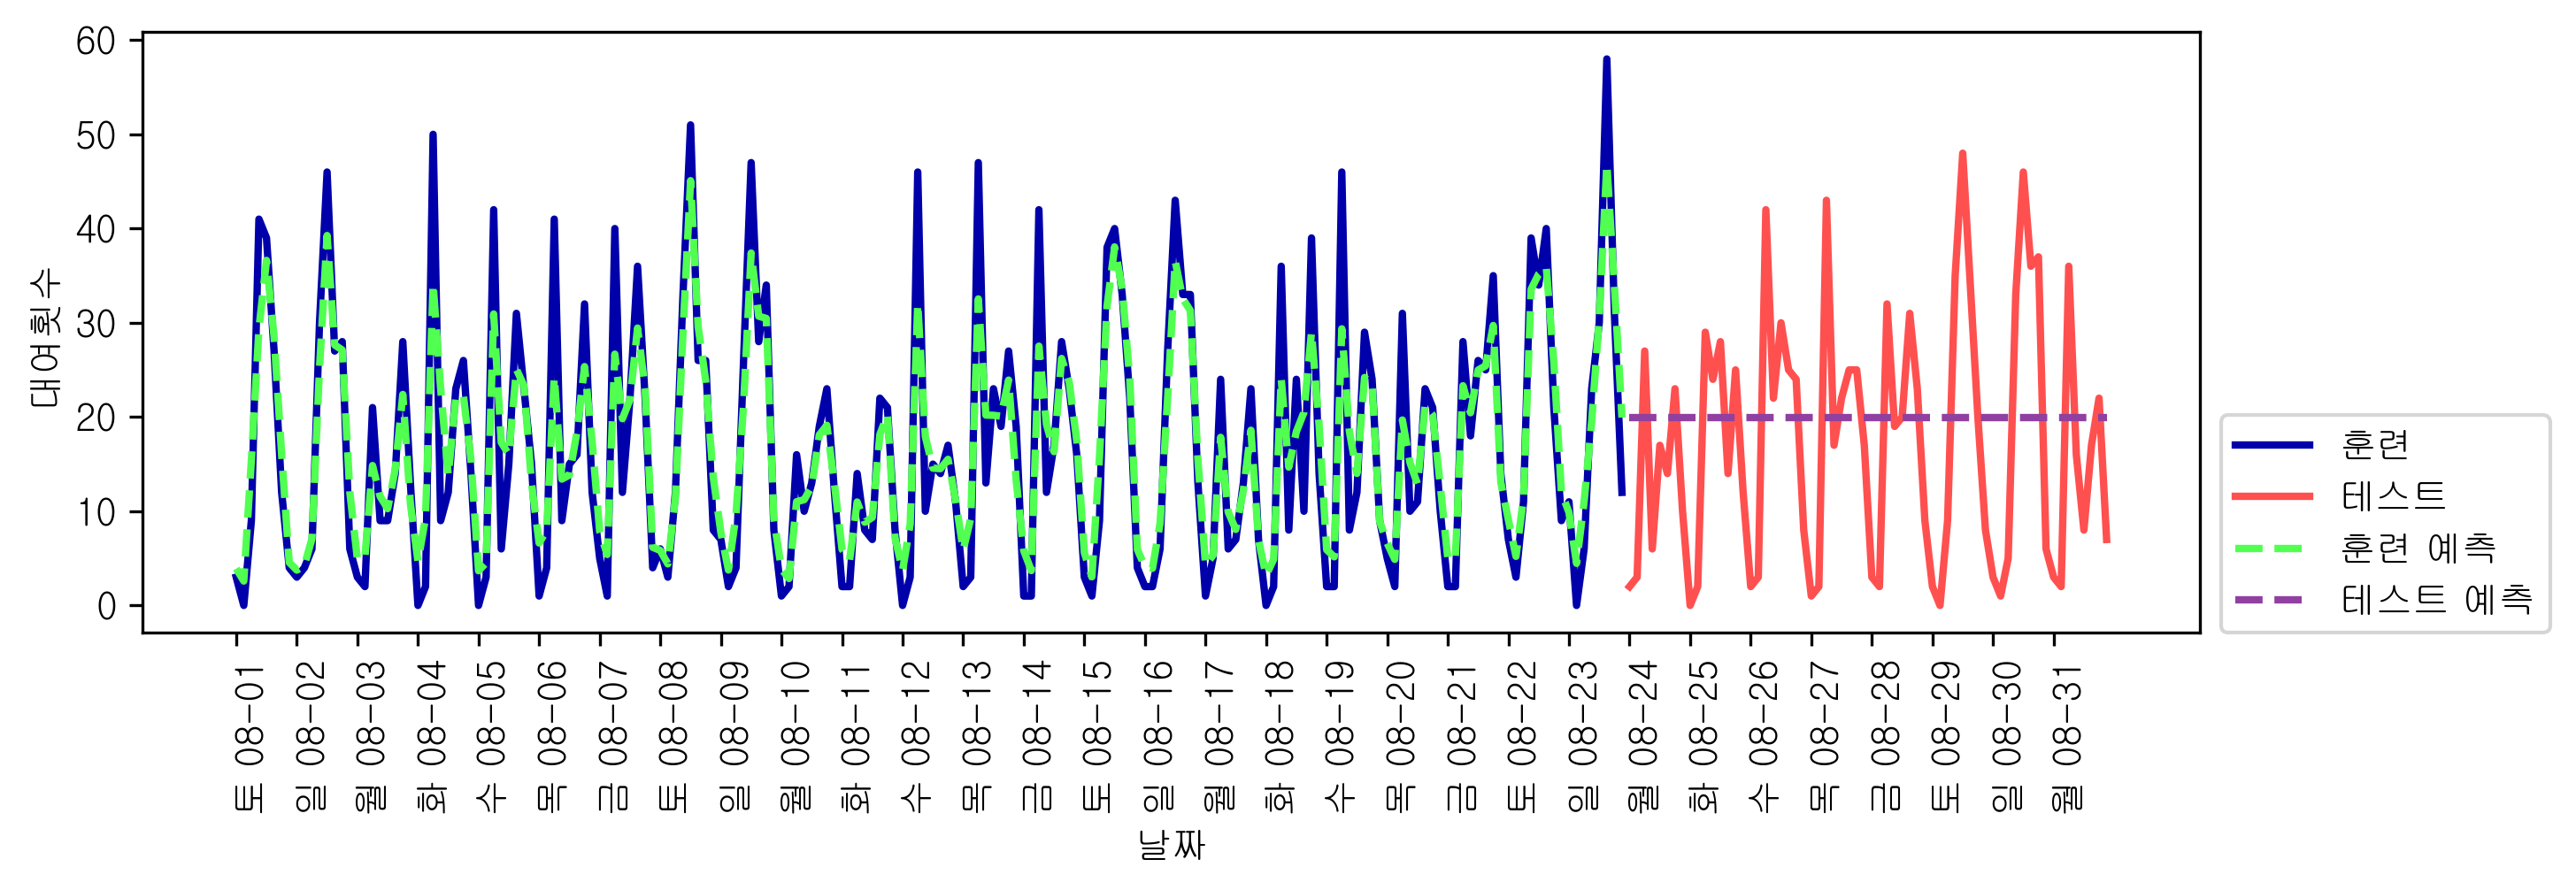

In [9]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators=100, random_state=0)
eval_on_features(X, y, regressor)

테스트 세트 R^2: 0.60


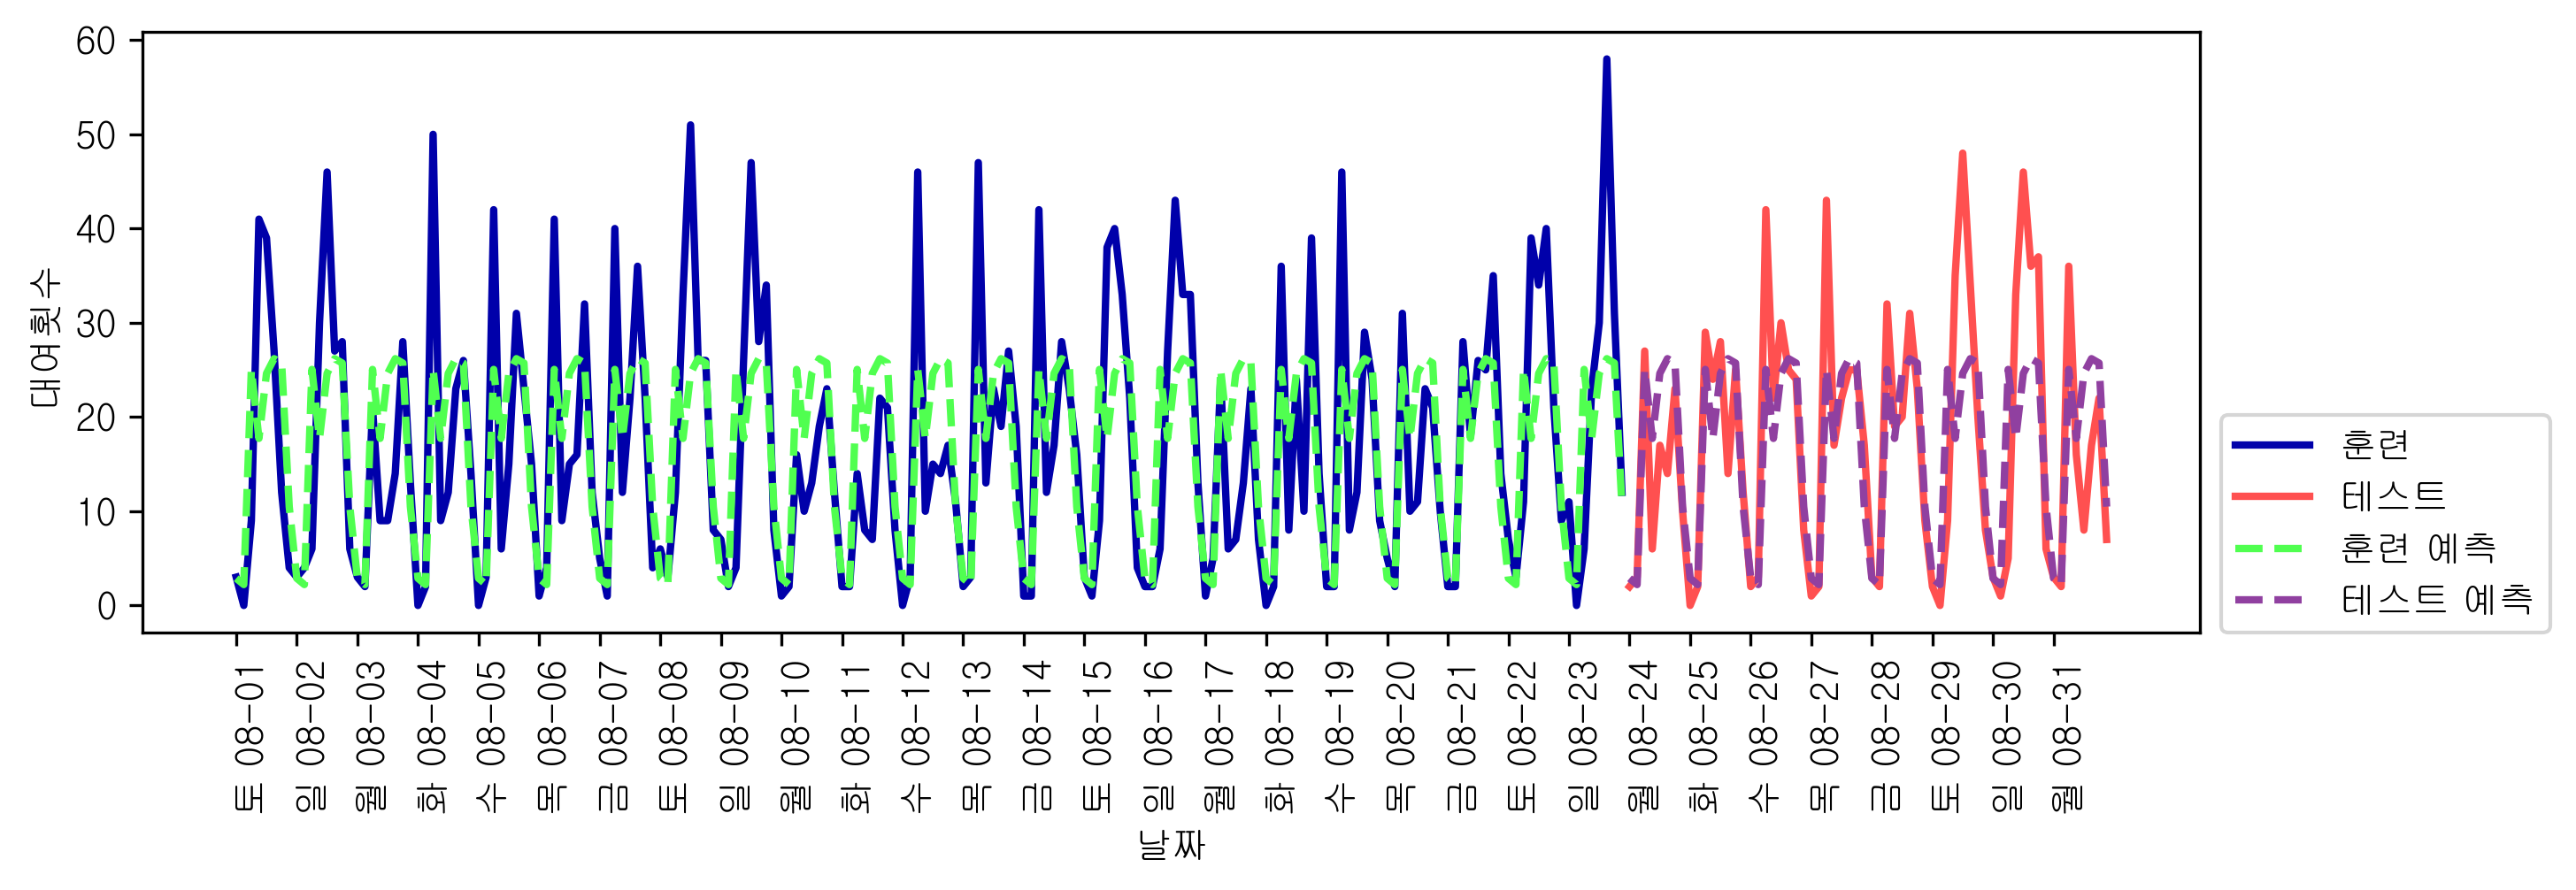

In [10]:
X_hour = citibike.index.hour.values.reshape(-1, 1)
eval_on_features(X_hour, y, regressor)

테스트 세트 R^2: 0.84


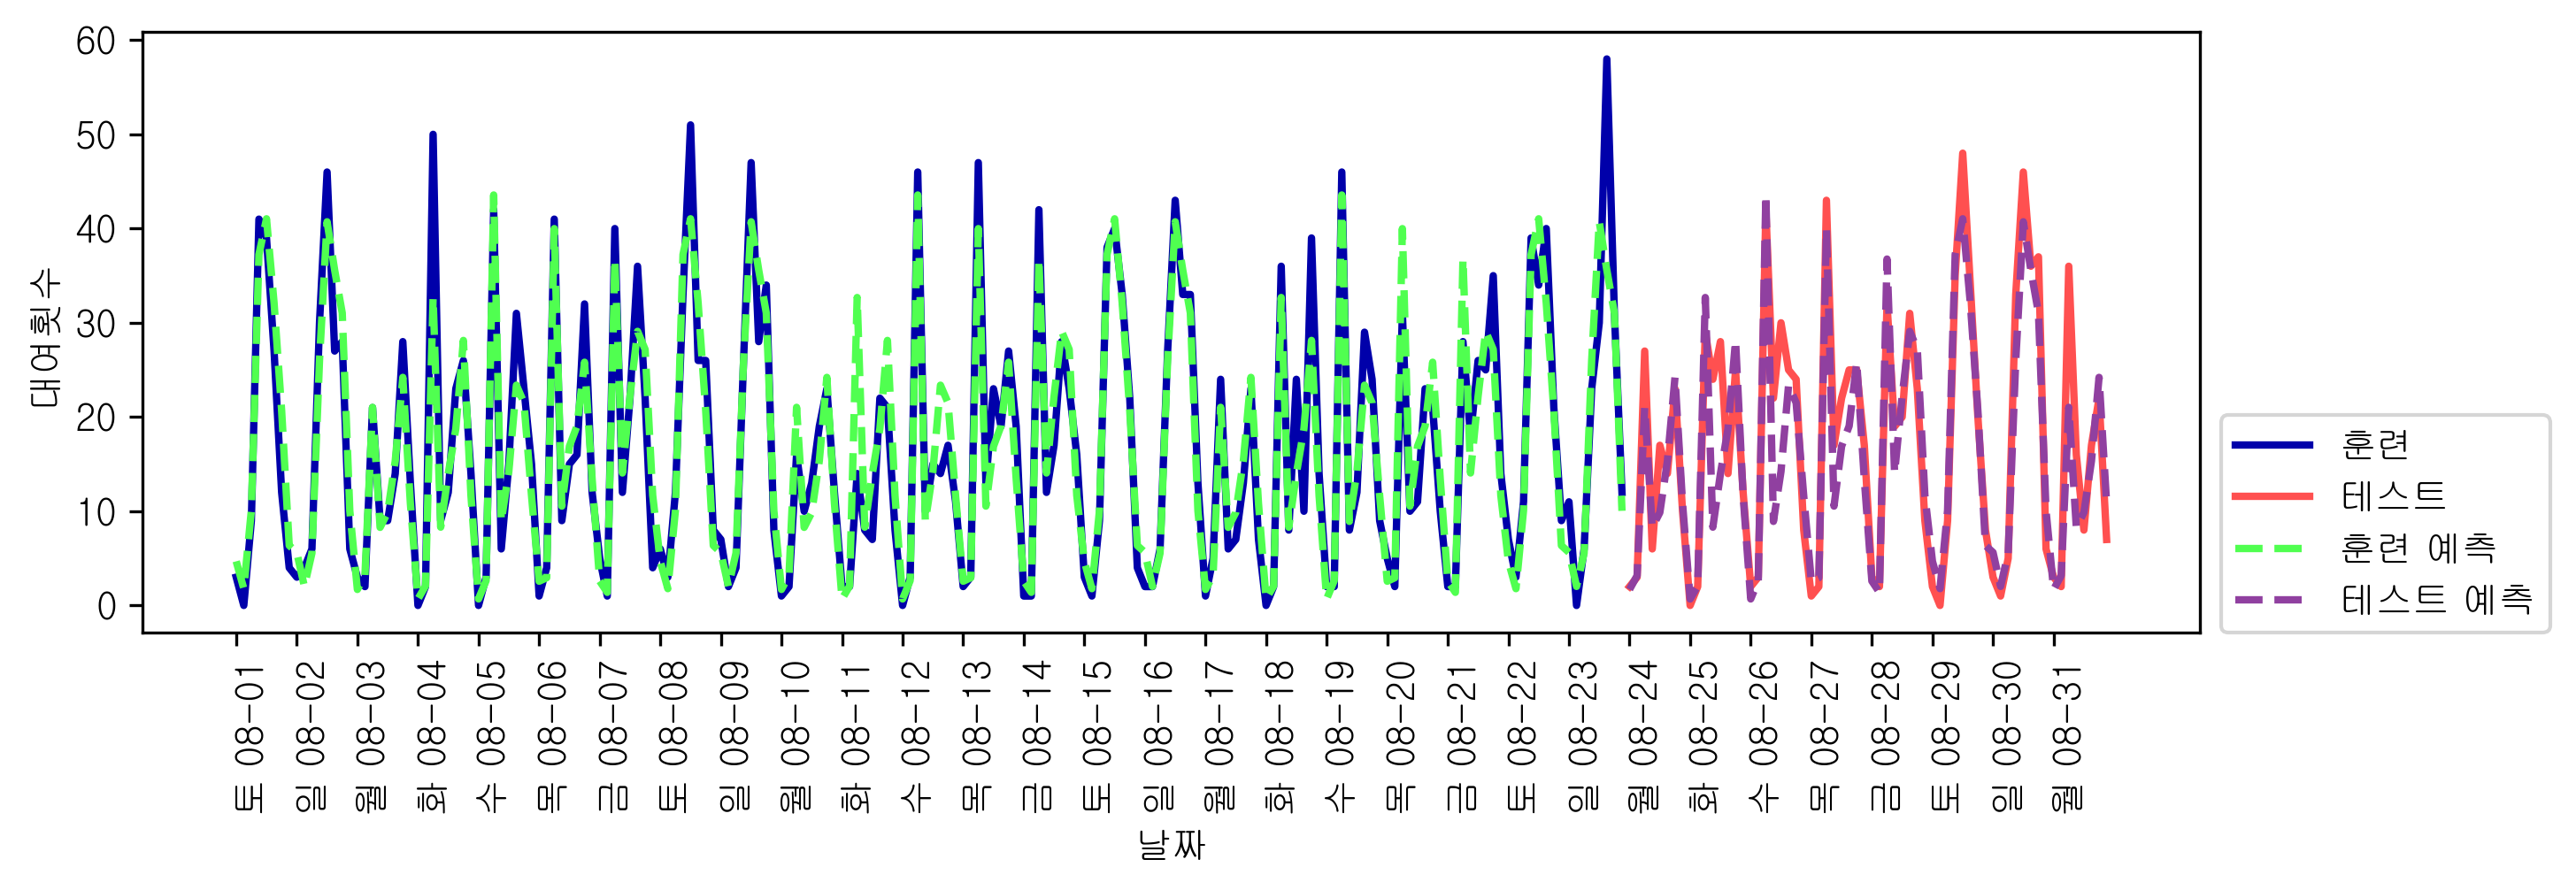

In [11]:
X_hour_week = np.hstack([citibike.index.dayofweek.values.reshape(-1, 1),
                         citibike.index.hour.values.reshape(-1, 1)])
eval_on_features(X_hour_week, y, regressor)

테스트 세트 R^2: 0.13


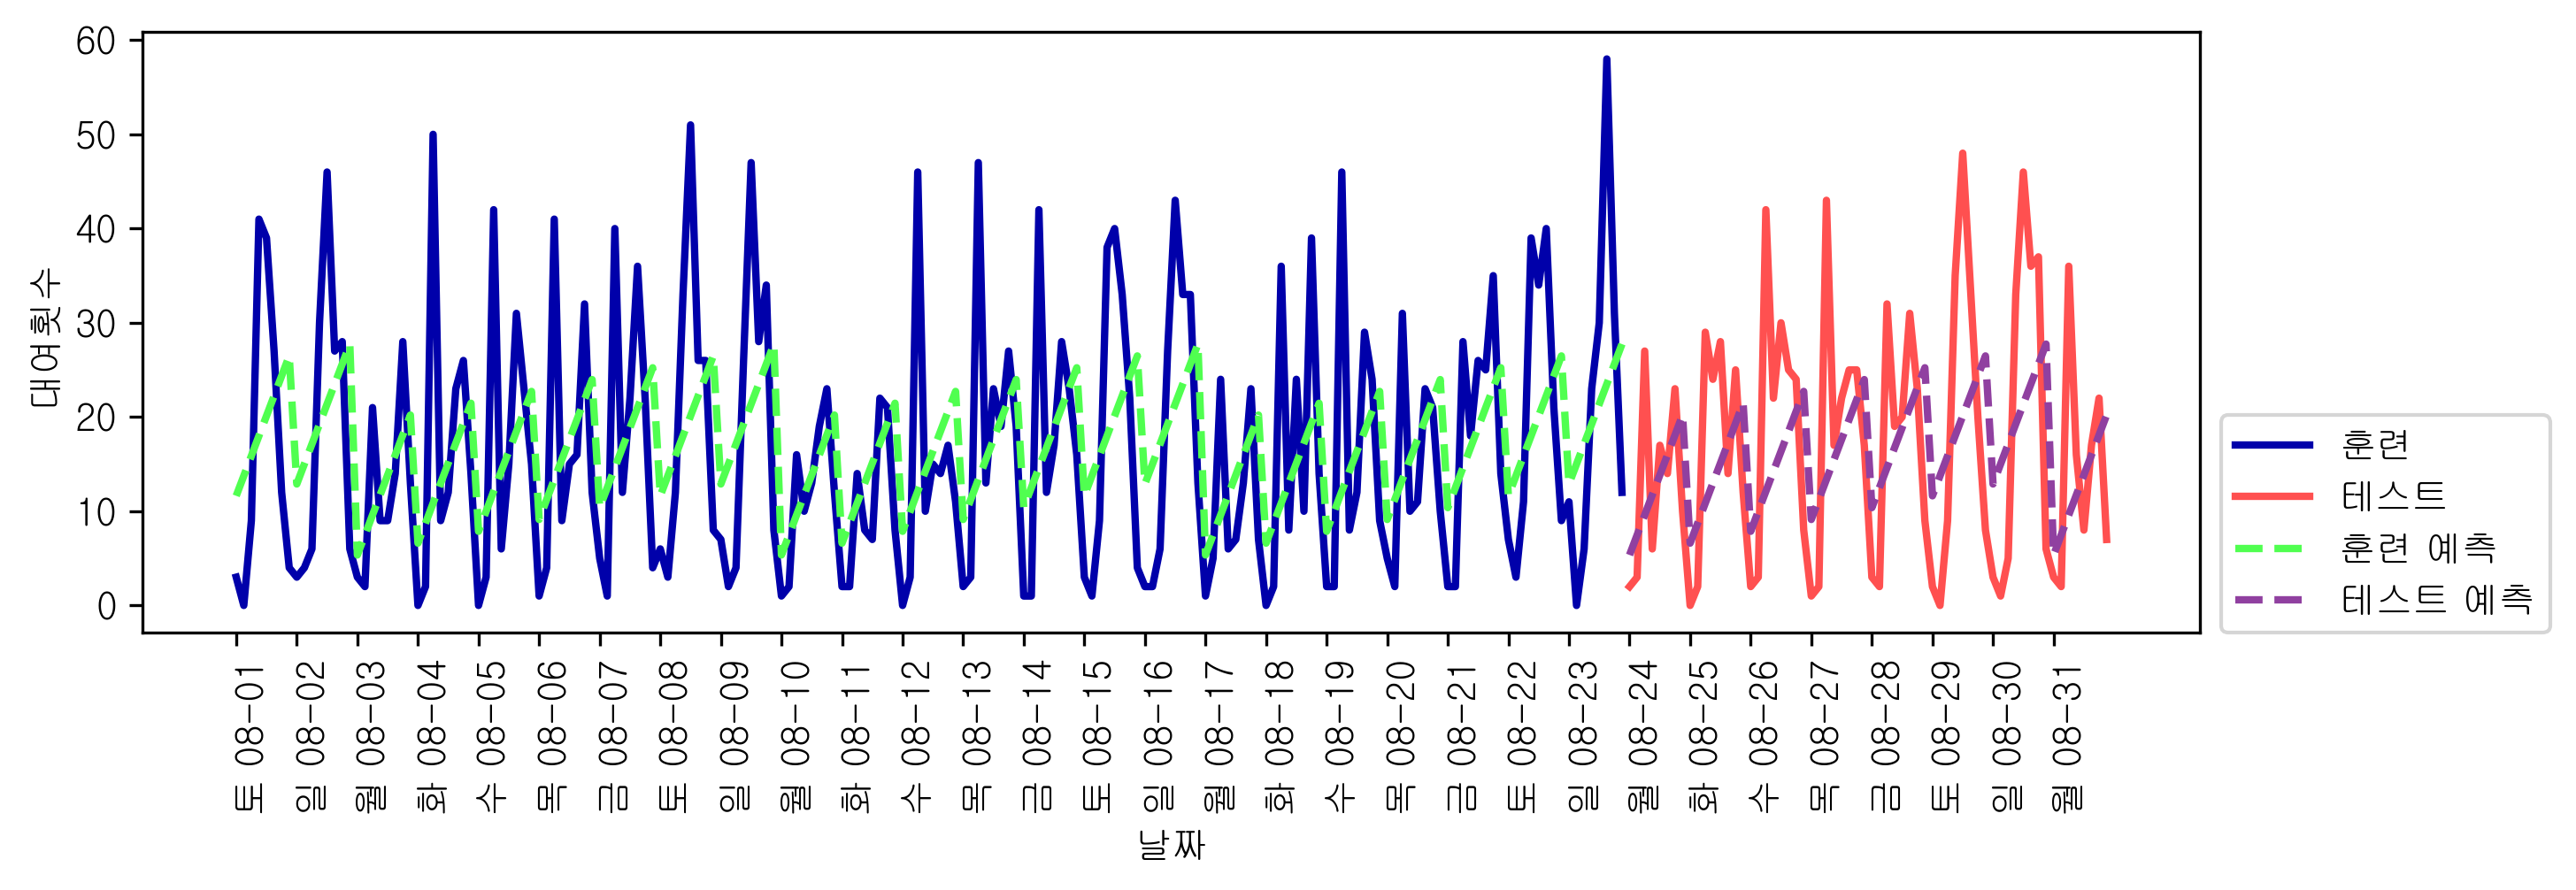

In [12]:
from sklearn.linear_model import LinearRegression
eval_on_features(X_hour_week, y, LinearRegression())

In [13]:
enc = OneHotEncoder()
X_hour_week_onehot = enc.fit_transform(X_hour_week).toarray()

테스트 세트 R^2: 0.62


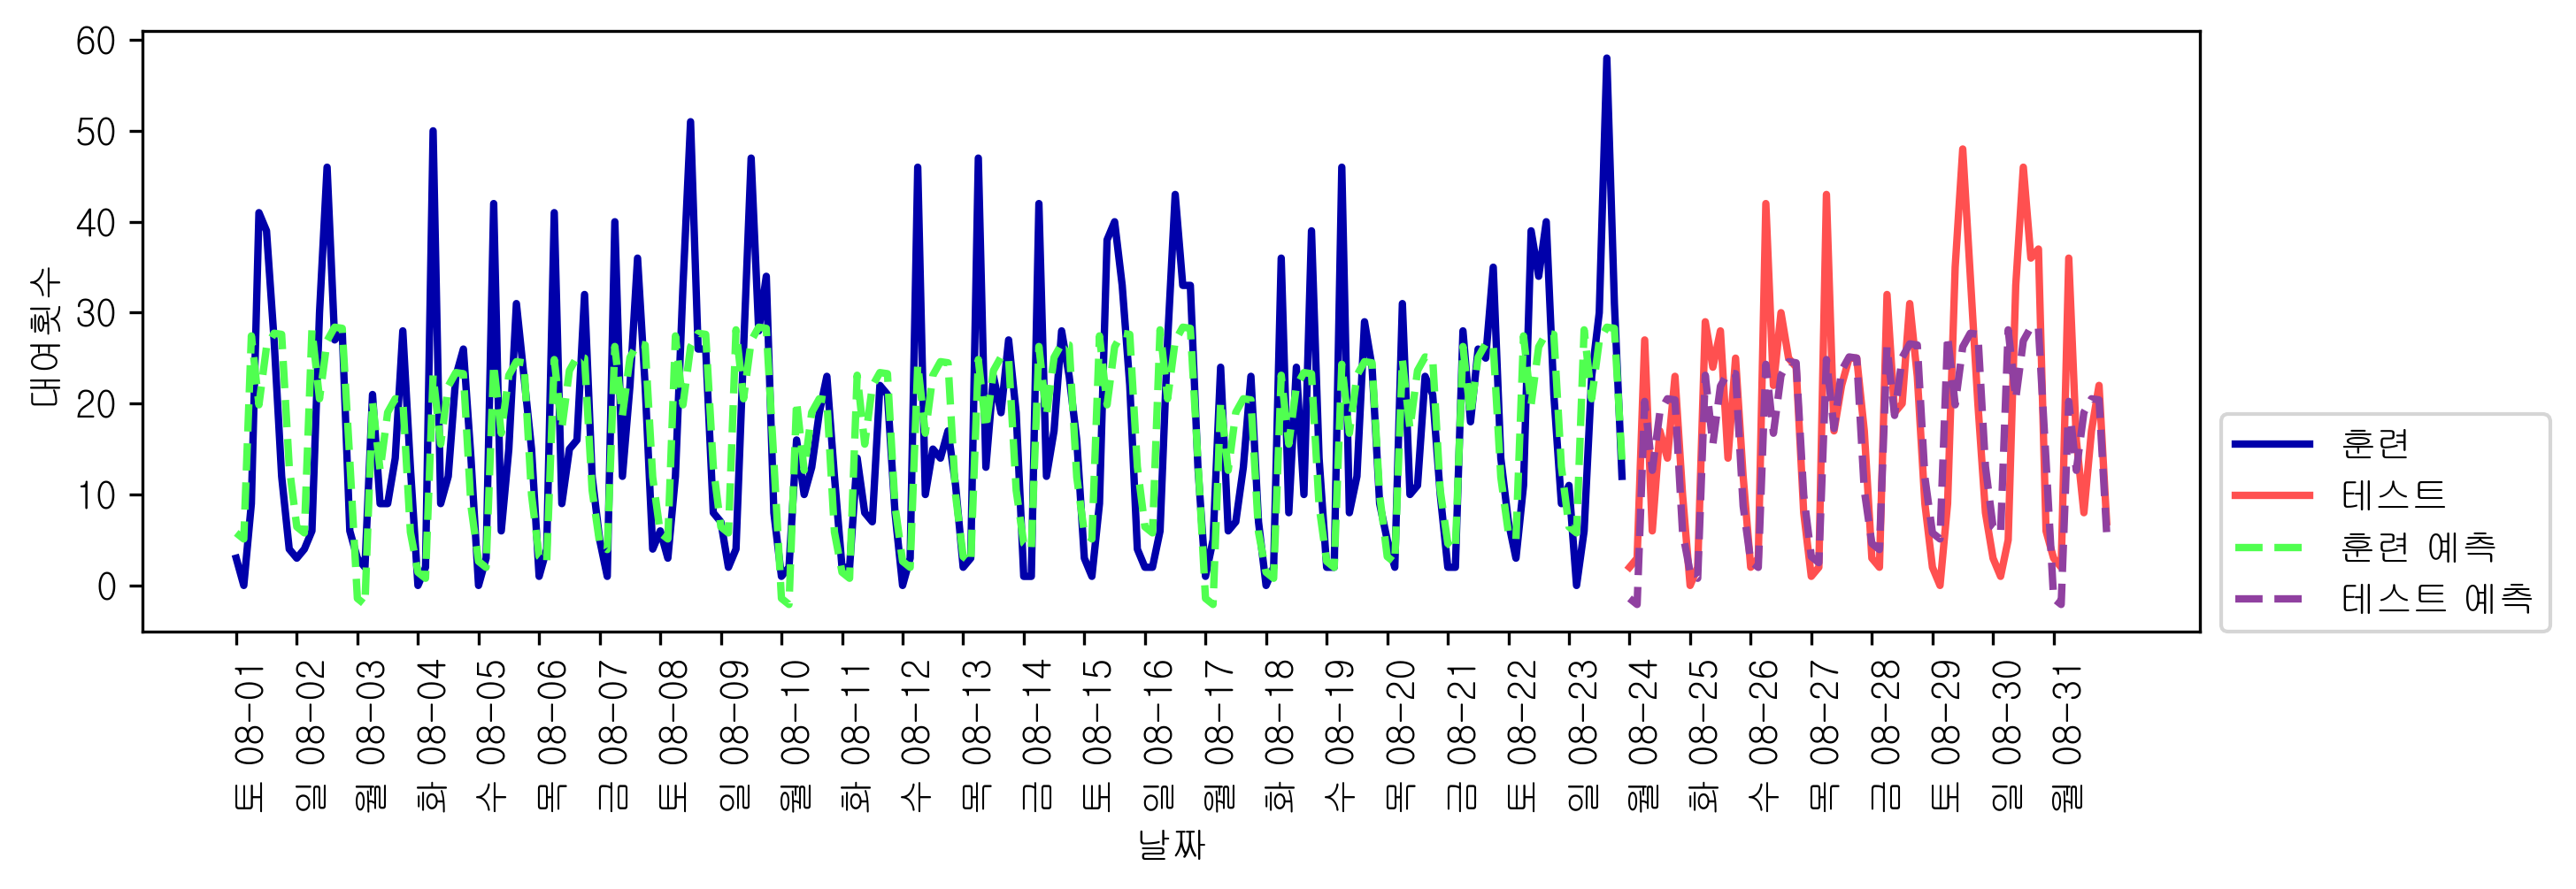

In [14]:
from sklearn.linear_model import Ridge

eval_on_features(X_hour_week_onehot, y, Ridge())

테스트 세트 R^2: 0.85


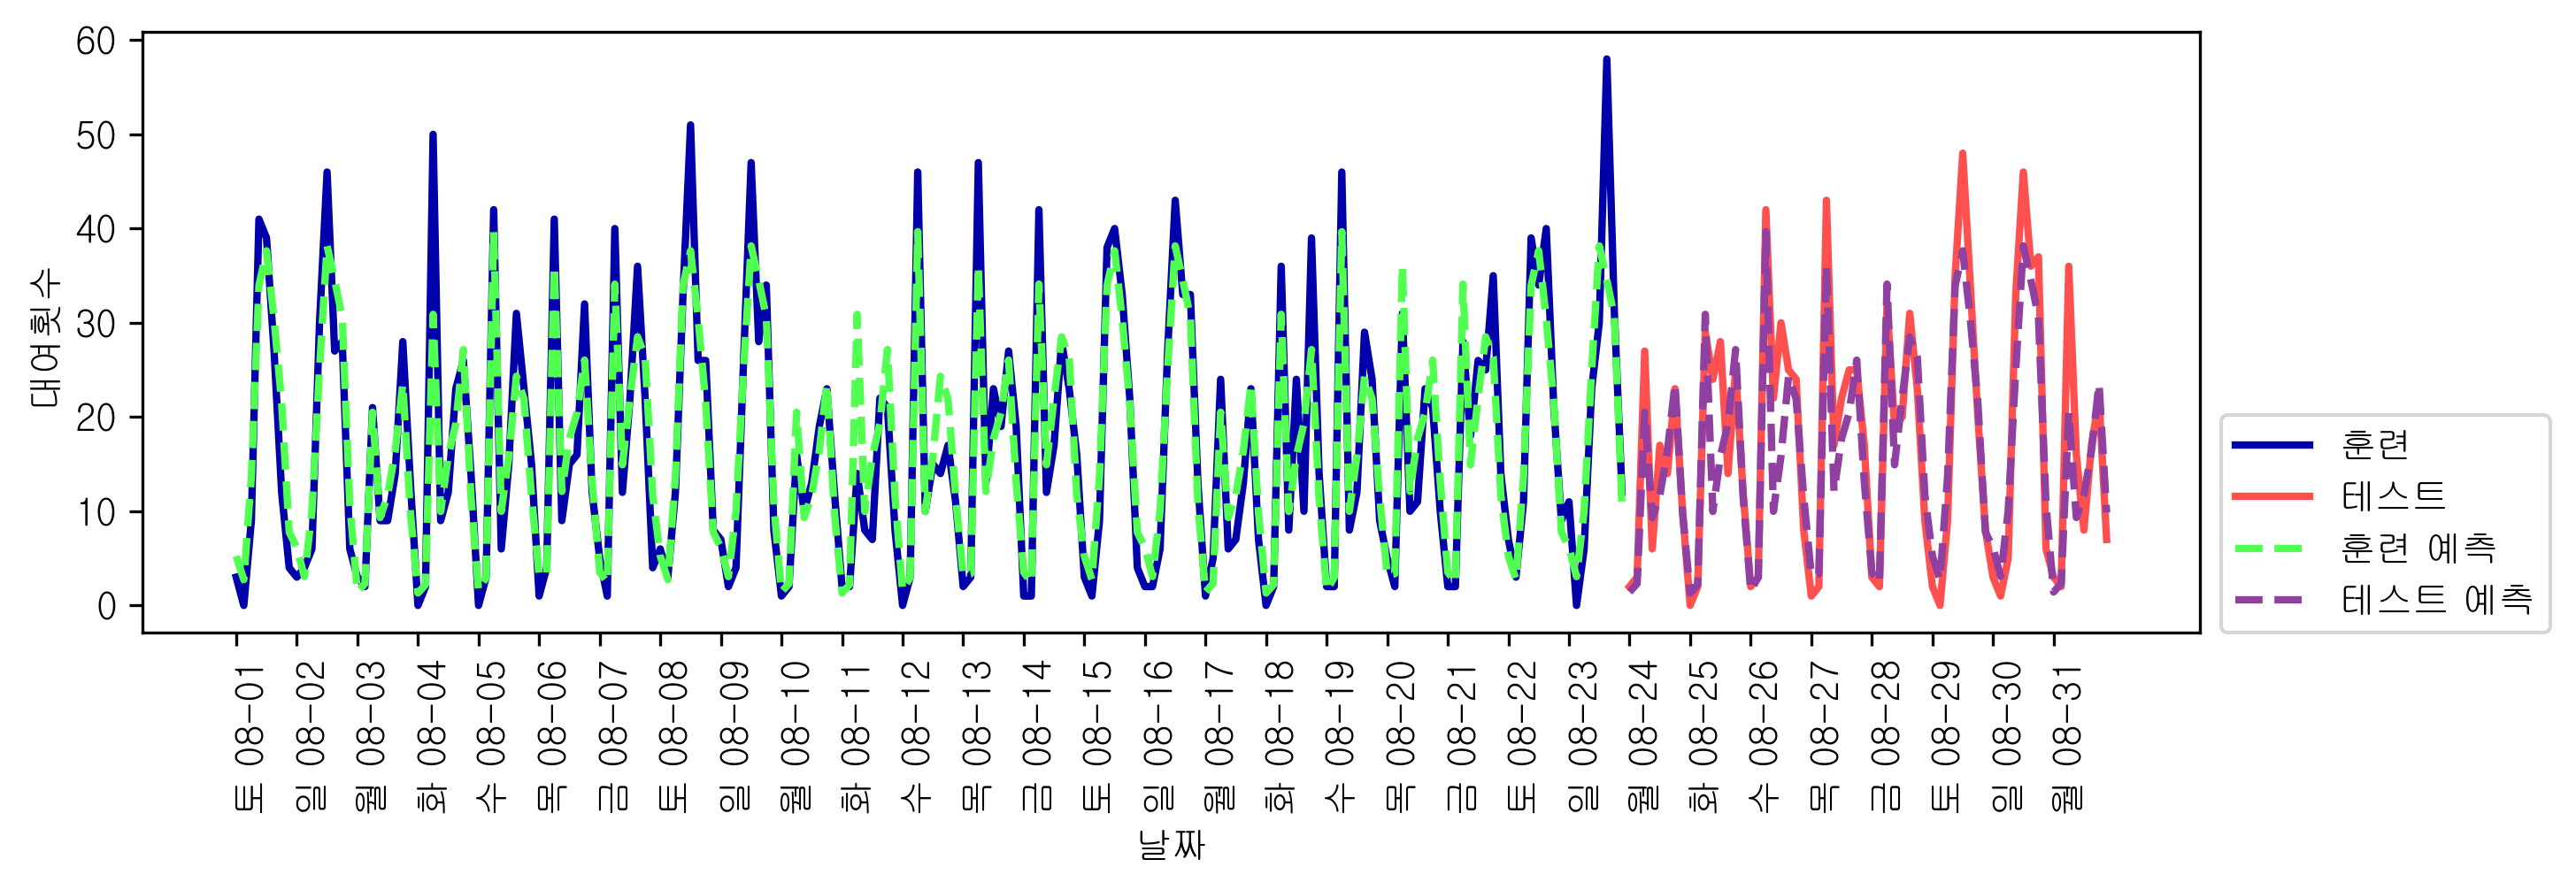

In [15]:
from sklearn.preprocessing import PolynomialFeatures

poly_transformer = PolynomialFeatures(degree=2, interaction_only=True,
                                      include_bias=False)
X_hour_week_onehot_poly = poly_transformer.fit_transform(X_hour_week_onehot)
lr = Ridge()
eval_on_features(X_hour_week_onehot_poly, y, lr)

In [16]:
hour = ["%02d:00" % i for i in range(0, 24, 3)]
day = ["월", "화", "수", "목", "금", "토", "일"]
features =  day + hour

In [17]:
features_poly = poly_transformer.get_feature_names(features)
features_nonzero = np.array(features_poly)[lr.coef_ != 0]
coef_nonzero = lr.coef_[lr.coef_ != 0]

Text(0,0.5,'계수 크기')

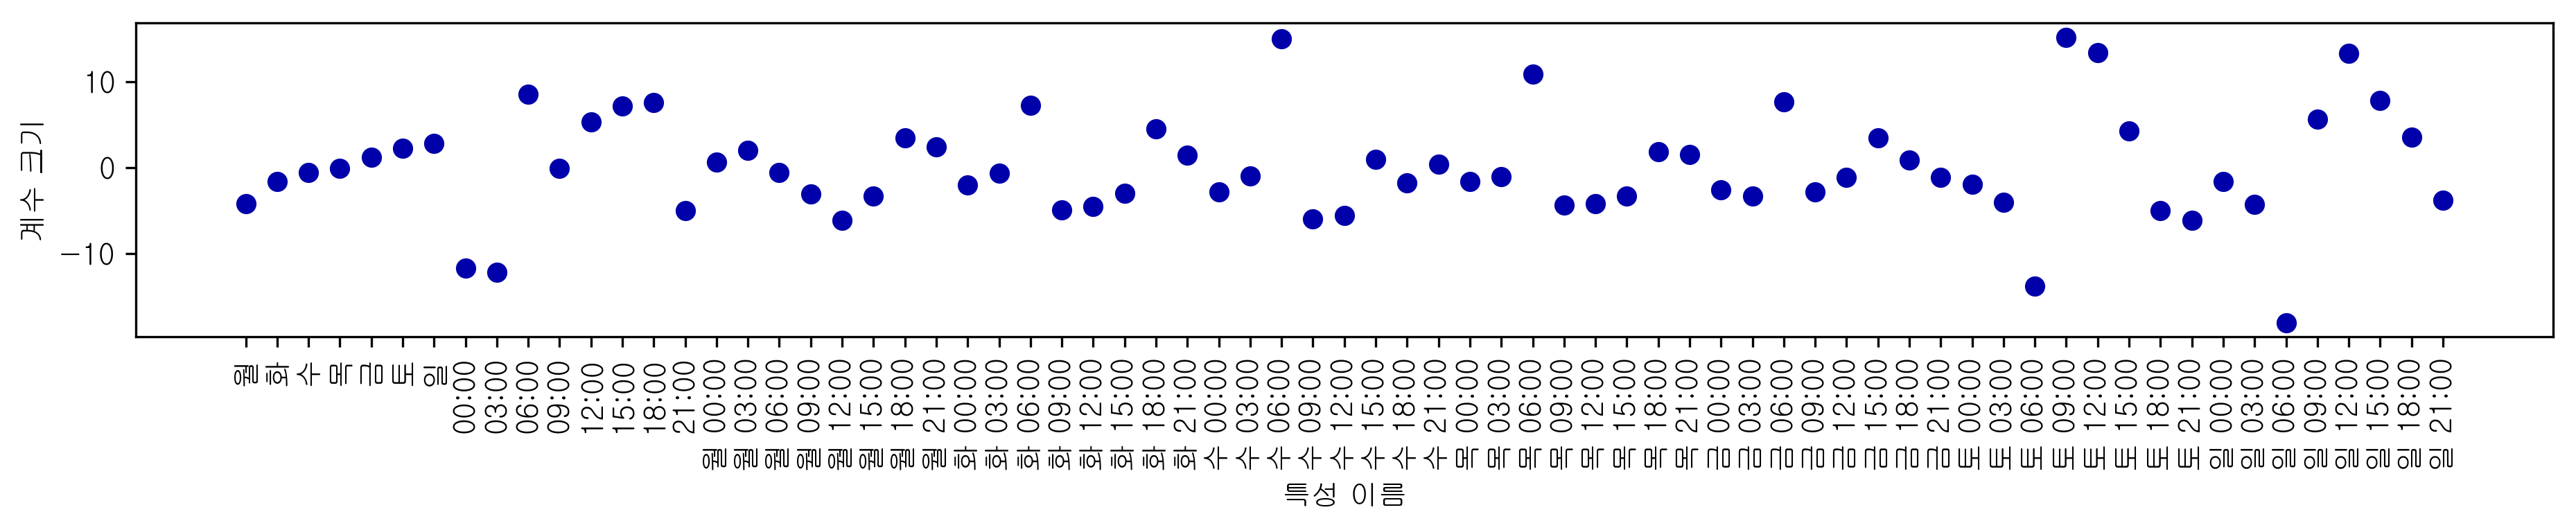

In [18]:
plt.figure(figsize=(15, 2))
plt.plot(coef_nonzero, 'o')
plt.xticks(np.arange(len(coef_nonzero)), features_nonzero, rotation=90)
plt.xlabel("특성 이름")
plt.ylabel("계수 크기")